<a href="https://colab.research.google.com/github/Ksenia-90/NN/blob/lesson_5/dz_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Рекуррентные нейронные сети

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
%matplotlib inline
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [79]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/airline-passengers.csv', parse_dates=['Month'], index_col=0)


In [80]:
data.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [81]:
data['year'] = data.index.year
data['month'] = data.index.month

In [82]:
def norm(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [83]:
train_split = 80
data_norm = norm(data.values, train_split)
data = pd.DataFrame(data_norm)

In [84]:
lIndexes = [0,1,2]
bias = 10
train_data = data.iloc[0 : train_split - 1,lIndexes]
test_data = data.iloc[train_split+bias:,lIndexes]

In [85]:
train_data.head()

,0,1,2
0,-1.434472,-1.476169,-1.555463
1,-1.328802,-1.476169,-1.261980
2,-1.082238,-1.476169,-0.968496
3,-1.135073,-1.476169,-0.675012
4,-1.275967,-1.476169,-0.381529


In [86]:
step = 1
maxlen = 3
h = 1
learning_rate = 0.001
batch_size = 42

In [87]:
x_train = train_data[[train_data.columns[i] for i in range(3)]].values
y_train = data.iloc[maxlen:(maxlen + train_split-1),0].values
x_test = test_data.iloc[:(len(test_data)) - maxlen+1][[test_data.columns[i] for i in range(3)]].values
y_test = data.iloc[(len(train_data)+bias+maxlen):,0].values

In [88]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=maxlen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=maxlen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [89]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (35, 3, 3)
Target shape: (35,)


In [90]:
epochs=300

callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(128, return_sequences="True"))
model.add(Conv1D(256, 3, activation='relu', padding='same'))
model.add(Conv1D(256, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="sgd", metrics=['mse'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_test)

Epoch 1/300
2/2 [==============================] - 5s 933ms/step - loss: 1.0644 - mse: 1.0644 - val_loss: 15.3829 - val_mse: 15.3829
Epoch 2/300
2/2 [==============================] - 0s 104ms/step - loss: 1.0245 - mse: 1.0245 - val_loss: 14.8443 - val_mse: 14.8443
Epoch 3/300
2/2 [==============================] - 0s 118ms/step - loss: 1.0003 - mse: 1.0003 - val_loss: 14.4582 - val_mse: 14.4582
Epoch 4/300
2/2 [==============================] - 0s 115ms/step - loss: 0.9829 - mse: 0.9829 - val_loss: 14.1635 - val_mse: 14.1635
Epoch 5/300
2/2 [==============================] - 0s 106ms/step - loss: 0.9680 - mse: 0.9680 - val_loss: 13.9241 - val_mse: 13.9241
Epoch 6/300
2/2 [==============================] - 0s 122ms/step - loss: 0.9545 - mse: 0.9545 - val_loss: 13.7203 - val_mse: 13.7203
Epoch 7/300
2/2 [==============================] - 0s 111ms/step - loss: 0.9414 - mse: 0.9414 - val_loss: 13.5335 - val_mse: 13.5335
Epoch 8/300
2/2 [==============================] - 0s 110ms/step - lo

In [91]:
predict= model.predict(dataset_train).flatten()
predict_test = model.predict(dataset_test).flatten()

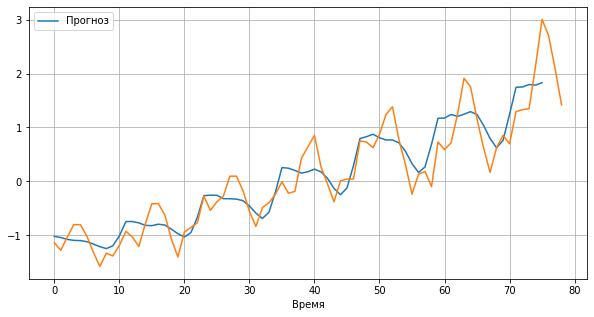

In [92]:
start = 0
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predict[h+start:h+train_split], 
         label='Прогноз')
plt.plot(y_train.flatten()[start:train_split])
plt.xlabel('Время')
plt.legend()
plt.show()